## Offline analysis

here we will explore

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
plt.style.use('science')

---
### Energy
Let us start this notebook by first analyzing the accuracy of our code. The gravitational problem is an example of an Hamiltonian system described by the Hamiltonian:
$$
H(\vec r, \vec v) = \frac{1}{2}\sum_i m_i v_i^2 + \frac{1}{2}\sum_{i\neq j} \frac{G m_i m_j}{r_{ij}}
$$
conserved (£H=const$) throughout the dynamical evolution of the closed system. Therefore, to assess the quality and stability of our numerical integrators, we can monitor the fluctuations of the computed empirical energy $E(t)$ over time. A stable integrator should maintain $E(t)$ nearly constant, with only bounded oscillations due to numerical precision.

We used two different integration schemes: **Velocity Verlet** (symplectic, stable) and **Euler** (first-order, unstable). For each integrator, we compared the total energy evolution $E(t)$ across three different hardware/software implementations:

1.  **Serial:** The baseline reference implementation. Code is executed on my CPU, single-thread
2.  **OpenMP:** Multi-threaded CPU execution. Code is executed in parallel thanks to OpenMP, still on the CPU
3.  **CUDA:** GPU execution

The specific parallelization paradigm (CPU, GPU ...) should not alter the *physics* of the solution, hence we should obtain similar results. However, to rigorously verify algorithmic correctness as a sanity check, these simulations were performed on all three implementations. Most importantly, we also analyized how switching from Double to Float may affect the energy conservation

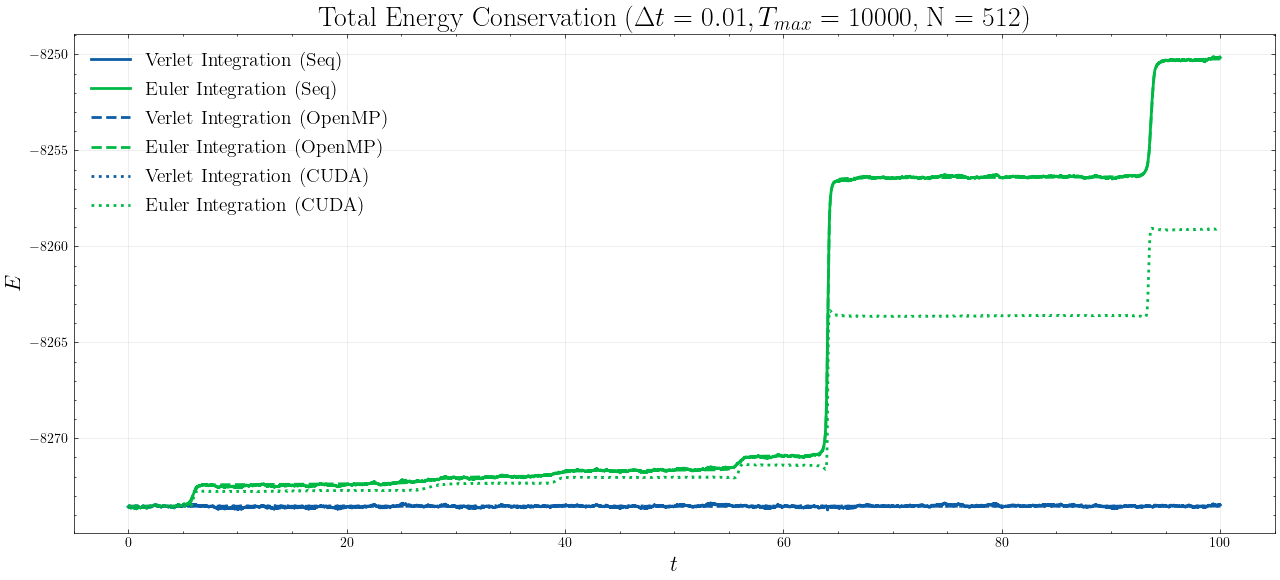

In [3]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUSequential/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, label='Verlet Integration (Seq)', lw = 2, color='C0')
plt.plot(time, energyEuler, label='Euler Integration (Seq)', lw = 2, color='C1')

# OpenMP, nthreads = 8 
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
filenameEuler = f"../data/CPUParallel/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, '--', label='Verlet Integration (OpenMP)', lw = 2,color='C0')
plt.plot(time, energyEuler, '--', label='Euler Integration (OpenMP)', lw = 2, color='C1')

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
filenameEuler = f"../data/GPU/energyEuler{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
dataEuler = np.loadtxt(filenameEuler)
energyVerlet = dataVerlet[:,3]
energyEuler = dataEuler[:,3]
time = dataVerlet[:,0]

plt.plot(time, energyVerlet, ':', label='Verlet Integration (CUDA)', lw = 2,color='C0')
plt.plot(time, energyEuler, ':', label='Euler Integration (CUDA)', lw = 2, color='C1')


plt.title(r'Total Energy Conservation     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As expected, Euler integration greatly violates energy conservation. This behavior is intrinsic to the algorithm: being a first-order method ($O(\Delta t)$), it introduces a systematic error at every time step. In orbital mechanics, this error manifests as a constant "energy drift," causing the system to gain non-physical energy: this is particularly evident for specific time where the energy abruptly increases. Those are points where bodies are colliding violently into each other and where the accuracy of Euler is at its lowest (causing injection of spurious energy into the system if $\Delta t$ is not small enough)

In contrast, the Velocity Verlet integrator demonstrates good stability. It preserves the geometric properties of the phase space and, while the energy is not conserved *exactly* (due to discrete time-stepping), it oscillates within a bounded interval rather than drifting linearly. This "bounded error" property makes Verlet suitable for long-term N-Body simulations.

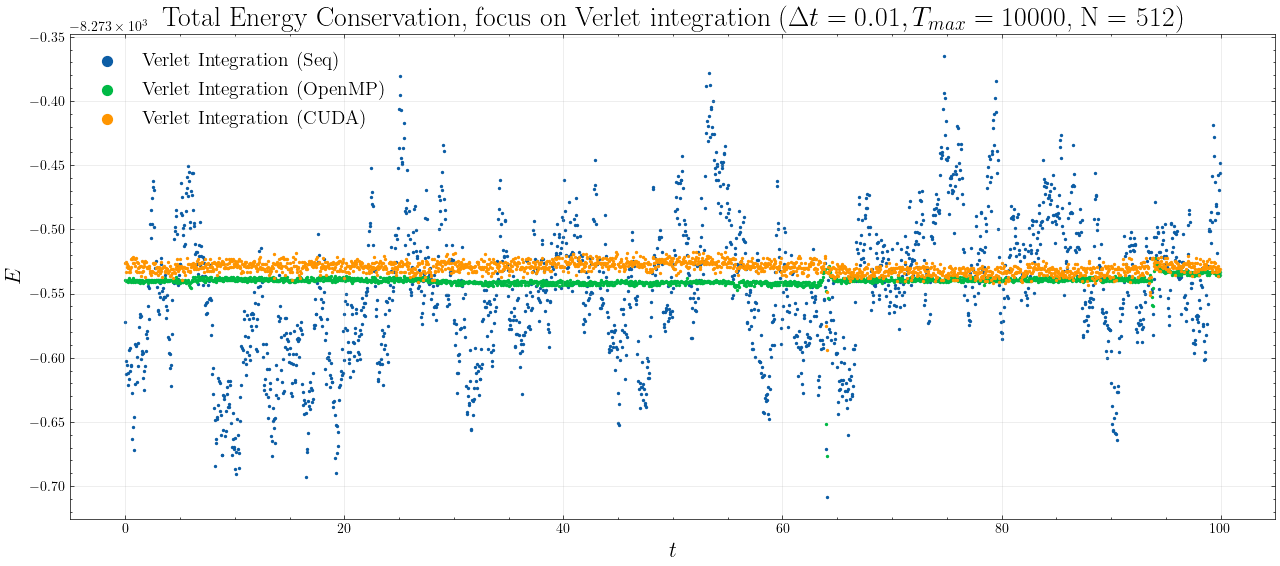

In [4]:
plt.figure(figsize=(13,6), dpi = 100)
prec = "Float"
# Sequential data
filenameVerlet = f"../data/CPUSequential/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (Seq)', s = 2)

# OpenMP, nthreads = 8 (but useless)
filenameVerlet = f"../data/CPUParallel/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (OpenMP)', s = 2)

# CUDA, naive
filenameVerlet = f"../data/GPU/energyVerlet{prec}.dat"
dataVerlet = np.loadtxt(filenameVerlet)
energyVerlet = dataVerlet[:,3]
time = dataVerlet[:,0]
plt.scatter(time[::5], energyVerlet[::5], label='Verlet Integration (CUDA)', s = 2)

plt.title(r'Total Energy Conservation, focus on Verlet integration     ($\Delta t = 0.01, T_{max} = 10000$, N = 512)', fontsize=20)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$E$', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, markerscale=5) 
plt.tight_layout()
plt.show()

For all three implementations (Sequential, OpenMP, and CUDA), the relative error in total energy remains sufficiently low and well-bounded. This confirms that the simulation avoid the unbounded energy drift typically associated with non-symplectic integrators, such as the Euler method. Quantitatively, we observe fluctuations of approximately $\pm 0.3$ against a total energy of $E \approx -8273$, corresponding to a relative error in the order of $10^{-5}$. Hence, the Verlet integrator will be used as numerical integrator for the remainder of this notebook.


An interesting phenomena can be observed: the numerical noise in the Verlet integrator appears slightly more pronounced in the Serial CPU implementation compared to the parallel versions. This behavior can be attributed to the non-associative nature of floating-point arithmetic (we used Float). In the serial implementation, potential energy is computed via a linear accumulation into a single variable. As the accumulator grows large, adding small subsequent contributions leads to a loss of precision due to truncation. In contrast, the parallel implementations (OpenMP and CUDA) inherently employ tree-reduction patterns or thread-local partial sums. These methods sum values of similar magnitude for a longer duration before the final aggregation, effectively acting as a numerical stabilizer and reducing the overall round-off error

## OpenMP: speedup and efficiency

We now proceed to analyze the computational performance of our simulation, specifically comparing the baseline implementation (**Serial CPU**) against the parallel implementation using OpenMP. The primary metric used for comparison is the wall-clock time required to complete a simulation of $N$ bodies for a total of $1000$ time-steps. To ensure the benchmark measures pure computational throughput (FLOPS) rather than disk latency, file I/O was disabled during these tests.

The timing measurement is implemented as follows (we do not want to measure the construction time too):

```cpp
Simulation sim(nParticles, dt, L);
auto start = std::chrono::high_resolution_clock::now();
sim.integrateVerlet(nSteps, nSteps, "", ""); // Don't save to IO!
auto end = std::chrono::high_resolution_clock::now();
std::chrono::duration<double> elapsed = end - start;
```

To extract a meaningful measure of the execution time, we repeat the execution $K = 15$ times (`timer.sh` script) and select the minimum time.

All CPU benchmarks (Sequential and OpenMP) were conducted on my personal laptop powered by an AMD Ryzen 7 7730U processor. The system configuration (`lscpu`) together with the compilation config is:
| Feature | Specification |
| :--- | :--- |
| **Processor** | AMD Ryzen™ 7 7730U |
| **Microarchitecture** | Zen 3 (x86_64) |
| **Physical Cores** | 8 |
| **Logical Threads** | 16 (Simultaneous Multithreading - SMT) |
| **Clock Speed** | Base 2.0 GHz / Boost up to 4.5 GHz |
| **Compiler** | GCC (g++) with flags: `-O3 -march=native -ffast-math (-fopenmp)` |

We will use openMP spawning $[2,4,8,16]$ threads.

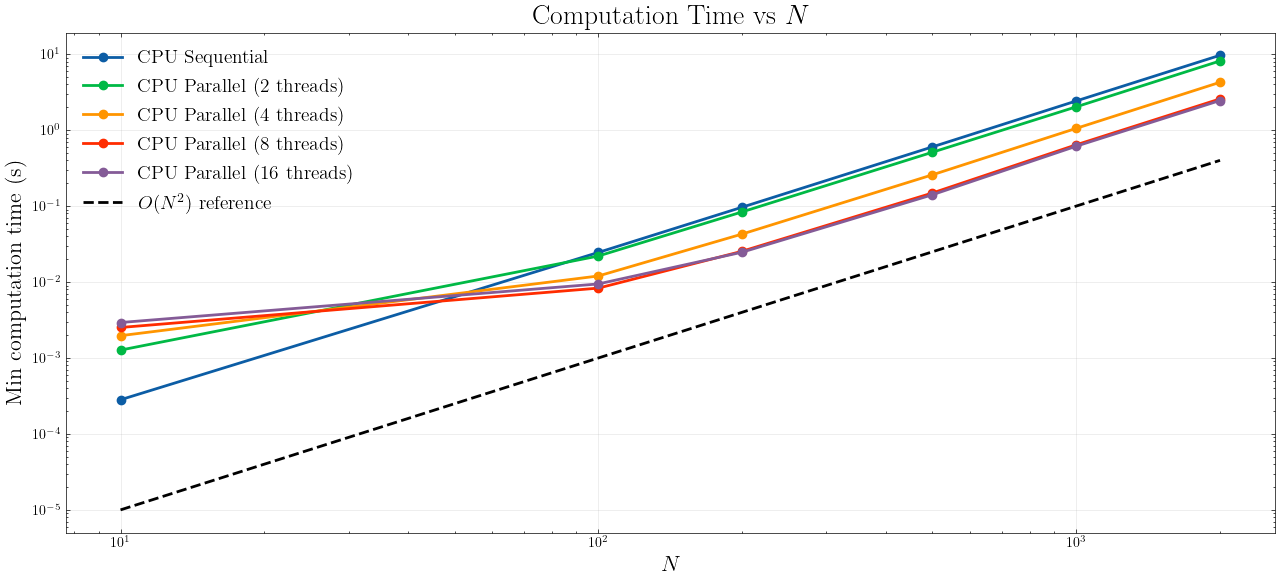

In [17]:
plt.figure(figsize=(13,6), dpi = 100)
# CP sequential
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
times = []

lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    times.append(np.min(buffer))
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"

    nParticles = []
    times = []

    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        times.append(np.min(buffer))
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)

plt.xscale('log')
plt.yscale('log')
N_ref = np.array(nParticles)
time_ref = 1e-7 * N_ref**2
plt.plot(N_ref, time_ref, '--', label=r'$O(N^2)$ reference', color='black', lw=2)
plt.title(r'Computation Time vs $N$', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Min computation time (s)', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As theoretically predicted, the execution time as a function of problem size (number of particles $N$) follows a quadratic scaling relation $O(N^2)$ for all configurations. This behavior is an intrinsic property of the naive direct-summation algorithm, which requires computing pairwise interactions between all particles. While the asymptotic trend remains quadratic, the varying slopes (representing the algorithmic pre-factors) demonstrate the efficiency of the parallel implementation: increasing the number of OpenMP threads progressively lowers the computational time for a given $N$. 

To provide a quantitative assessment of the OpenMP performance relative to the sequential baseline, we evaluate the Speedup $S_p(N)$ for each system size.

Speedup with 2 threads: 1.1859625689502662
Speedup with 4 threads: 2.298380785513244
Speedup with 8 threads: 3.860058436643557
Speedup with 16 threads: 4.049969088963325


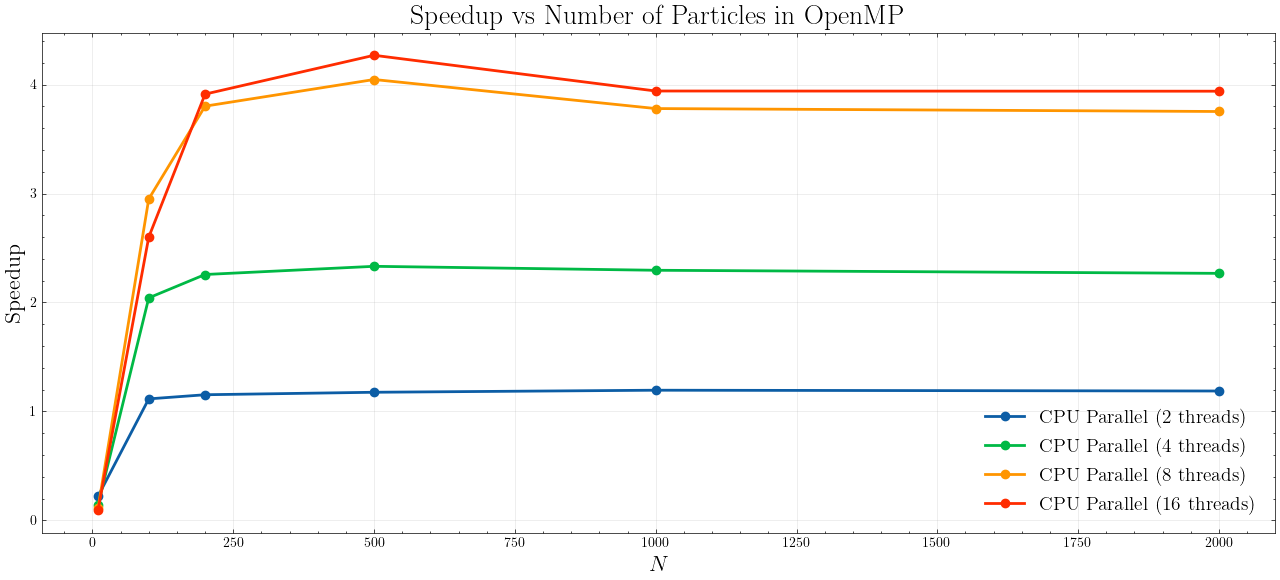

In [22]:
## Speedup in OpenMP
plt.figure(figsize=(13,6), dpi = 100)
# Sequential data
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
timesSeq = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesPar = []
for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    timesPar = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))
    speedup = np.array(timesSeq)/np.array(timesPar)
    plt.plot(nParticles, speedup, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup with {t} threads: {np.mean(speedup[3:])}")

plt.title(r'Speedup vs Number of Particles in OpenMP', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Speedup', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

As the number of threads increases, the speedup improves significantly, reaching a saturation plateau of approximately $4\times$ when utilizing 8 or 16 threads. The graph shown above allows us to draw three key conclusions regarding the performance and architecture of the simulation:

1) For sufficiently large $N$ (where parallelization overhead becomes negligible), the speedup remains roughly constant with respect to the problem complexity. This constant scaling behavior serves as a robust sanity check, confirming that the parallel overhead is well-amortized and the workload is evenly distributed among threads.

2) The speedup scales linearly up to 8 threads, but the performance gain between 8 and 16 threads is marginal. This behavior is dictated by the hardware architecture: my CPU possesses 8 physical cores. While SMT (Simultaneous Multithreading, similar to Intel HyperThreading) technology exposes 16 logical cores to the SO, pairs of threads running on the same physical core must share the same execution units (ALU/FPU). Consequently, once the 8 physical cores are saturated, enabling SMT provides only a slight throughput improvement before bottlenecking on the shared hardware resources.

3) When using $k$ threads, we might want to obtain a speedup of about $k$ (efficiency $100\%$). Here, we systematically get a speedup of about $0.5k$ (efficiency $50\%$). Why is that? The point here is that we have not been really fair. The serial implementation leverages Newton third law to reduce by half the number of computations needed to obtain the force vector. In the OpenMP implementation, this can't be done easily since threads work independently and we may encounter racae conditions if a thread updates the force on the second particle of the pair (particle j) while another thread is simultaneously attempting to write to the same memory location. Hence, the openMP implementation has to carry out twice the amount of computations performed by the sequential implementation.

We might want to explore what happens if we insist on using Newton's Third Law in parallel. One might attempt to implement a version where threads compute only the unique pairs ($j > i$) and use atomic operations (`#pragma omp atomic`) to safely update the forces on both particles (`computeForces2()`):

Speedup with 2 threads: 0.19831440211601278
Speedup with 4 threads: 0.19125953493370182
Speedup with 8 threads: 0.2741761074941586
Speedup with 16 threads: 0.6477725937059043


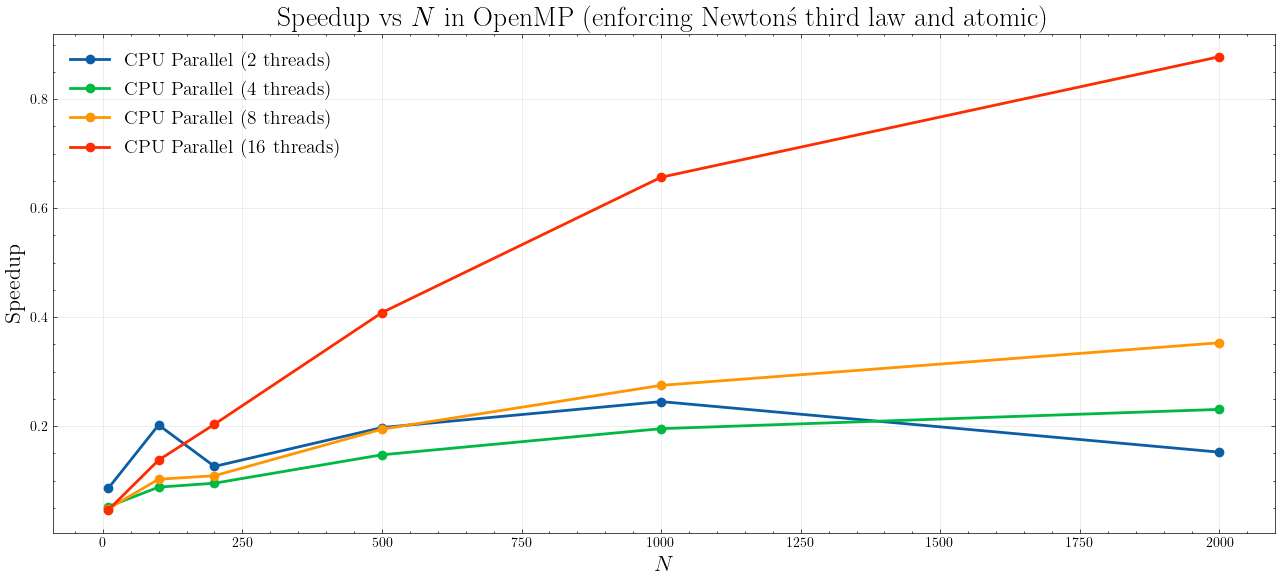

In [27]:
## Speedup in OpenMP
plt.figure(figsize=(13,6), dpi = 100)
# Sequential data
filename = "../data/CPUSequential/timeVersusN.dat"
REP = 15
threads = [2, 4, 8, 16]

nParticles = []
timesSeq = []
lines = open(filename).read().splitlines()
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    timesSeq.append(np.min(buffer))

timesPar = []
for t in threads:
    # CPU parallel
    filename = f"../data/CPUParallel/timeVersusN_{t}t_2.dat"
    nParticles = []
    timesPar = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        timesPar.append(np.min(buffer))
    speedup = np.array(timesSeq)/np.array(timesPar)
    plt.plot(nParticles, speedup, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup with {t} threads: {np.mean(speedup[3:])}")

plt.title(r'Speedup vs $N$ in OpenMP (enforcing Newton\'s third law and atomic)', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'Speedup', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

The outcome of this experiment is negative: the atomic implementation proves to be significantly slower than even than the sequential baseline. The computational overhead introduced by the extra synchronization required to perform the atomic sums completely overwhelms the benefit derived from halving the floating-point operations.


Interestingly, extending the parallelism to 16 threads (utilizing SMT/Hyperthreading) yields a measurable performance gain over the 8-thread configuration (still poor with respect to baseline sequential). This is to be expected, however. Since two logical threads residing on the same physical core share the same ALU/FPU resources, they cannot execute arithmetic instructions simultaneously and in parallel. However, the core's scheduler can interleave their instruction pipelines to maximize utilization. For example, when one thread is locked waiting for a  `#pragma omp atomic` operation, the sibling thread can immediately utilize these idle cycles to perform its own computations on the shared ALU. Consequently, SMT/HyperThreading effectively converts the "wasted" time of atomic synchronization into useful work, explaining the superior scaling observed in the memory-bound implementation.

As a final check, let us compute the FLOPS of our implementations (Floating Point Operation per Second). At each time step and for each particle, we have to compute:
```cpp
...
// Memory fetching
float dx = m_x[j] - m_x[i];                  (+1)
float dy = m_y[j] - m_y[i];                  (+1)
float dz = m_z[j] - m_z[i];                  (+1)
// Apply Minimum Image Criterion
dx -= m_L * std::round(dx * inv_m_L);        (+2+round)
dy -= m_L * std::round(dy * inv_m_L);        (+2+round)
dz -= m_L * std::round(dz * inv_m_L);        (+2+round)

Real r2 = dx*dx + dy*dy + dz*dz + 1e-2f;         (+7)
Real r = std::sqrt(r2);                          (+sqrt)
Real f_mag = (m_mass[i] * m_mass[j]) / (r2 * r);  (+3)
// Update forces on both i and j
m_fx[i] += f_mag * dx;                           (+2)
m_fy[i] += f_mag * dy;                           (+2)
m_fz[i] += f_mag * dz;                           (+2)
m_fx[j] -= f_mag * dx;                           (+2)
m_fy[j] -= f_mag * dy;                           (+2)
m_fz[j] -= f_mag * dz;                           (+2)
...

``` 
Let us perform a back-of-the-envelope estimate. Let us count the function `std::round` and `std::sqrt` as a 1 FLOP, hence we will have approximately $35$ FLOP at each time step. Considering we take $1000$ integration step computing $N^2/2$ forces (or $N^2$), we have:
$$
GFLOPS_{serial} \approx \frac{35 N^2 N_{step}}{2t_{min}\times 10^9}
$$
$$
GFLOPS_{parallel} \approx \frac{35 N^2 N_{step}}{t_{min}\times 10^9}
$$

Average GFLOPS (sequential): 7.242828275321474
Speedup on GFLOPS with 2 threads: 2.37188235925232
Speedup on GFLOPS with 4 threads: 4.596884044404223
Speedup on GFLOPS with 8 threads: 7.72084658777955
Speedup on GFLOPS with 16 threads: 8.10080619255896


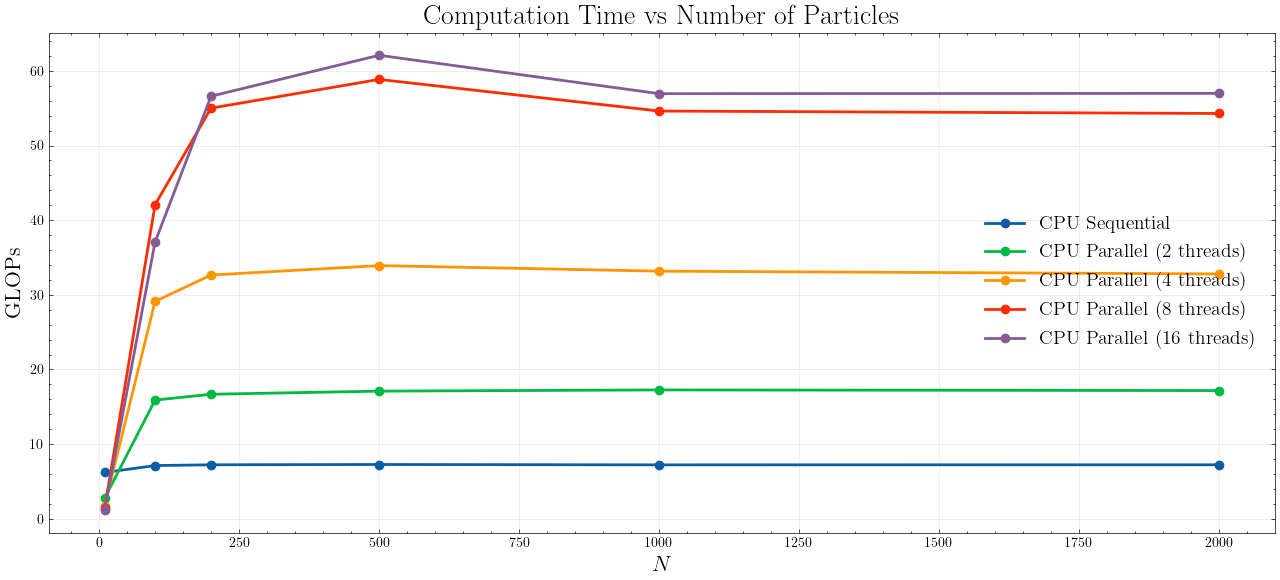

In [32]:
steps = 1000
ops_per_interaction = 35.0  # an approx, of course
REP = 15
threads = [2, 4, 8, 16]
plt.figure(figsize=(13,6), dpi = 100)


nParticles = []
times = []
filename = "../data/CPUSequential/timeVersusN.dat"
lines = open(filename).read().splitlines()
avgGFLOPS = 0
for i in range(0, len(lines), REP):
    block = lines[i:i+REP]
    bufferParticles = []
    buffer = []
    for line in block:
        vals = line.split()
        bufferParticles.append(int(vals[0]))
        buffer.append(float(vals[1]))
    nParticles.append(np.min(bufferParticles))
    total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
    times.append(total_ops / (2*np.min(buffer)*1e9))  # Convert to GFLOPS
avgGFLOPS = np.mean(times[3:])
print(f"Average GFLOPS (sequential): {avgGFLOPS}")
plt.plot(nParticles, times, '-o', label='CPU Sequential', lw = 2)

for t in threads:
    filename = f"../data/CPUParallel/timeVersusN_{t}t.dat"
    nParticles = []
    times = []
    lines = open(filename).read().splitlines()
    for i in range(0, len(lines), REP):
        block = lines[i:i+REP]
        bufferParticles = []
        buffer = []
        for line in block:
            vals = line.split()
            bufferParticles.append(int(vals[0]))
            buffer.append(float(vals[1]))
        nParticles.append(np.min(bufferParticles))
        total_ops = (np.min(bufferParticles)**2) * steps * ops_per_interaction
        times.append(total_ops / (np.min(buffer)*1e9))  # Convert to GFLOPS
    plt.plot(nParticles, times, '-o', label=f'CPU Parallel ({t} threads)', lw = 2)
    print(f"Speedup on GFLOPS with {t} threads: {np.mean(times[3:])/avgGFLOPS}")

plt.title(r'Computation Time vs Number of Particles', fontsize=20)
plt.xlabel(r'$N$', fontsize=16)
plt.ylabel(r'GLOPs', fontsize=16)
plt.grid(alpha=0.3)
plt.legend(fontsize=14, loc='best')
plt.tight_layout()
plt.show()

The GFLOPS analysis reveals the true efficiency of the parallel implementation, resolving the apparent discrepancy observed in the speedup charts. Remarkably, when utilizing 8 threads, we observe a computational throughput that is approximately 7 times higher than the serial baseline (a better efficiency!)

This result confirms that the bottleneck in the speedup (which is limited to $\approx 4\times$) is purely algorithmic, not architectural. By calculating the full interaction matrix ($N^2$) instead of unique pairs ($N^2/2$), the parallel implementation performs exactly twice the amount of useful work per time step. The fact that the GFLOPS metric scales linearly with the physical core count proves that the OpenMP overhead is negligible and that the memory subsystem is successfully feeding data to all 8 cores simultaneously without significant contention.